In [1]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from scipy.special import iv
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def mets_filter(ts,rho,alpha):
    ts_mean = np.mean(ts)
    ts = np.append(ts,ts_mean)
    sample_size = len(ts)
    
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1

    L_approx[sample_size -1 ] = np.zeros(sample_size)
    filter_matrix = expm(rho*L_approx)
    
    output = np.dot(filter_matrix,ts) + alpha

    return output[:-1]


def ols_mets(ts, grid_size):
    sample_size = len(ts)
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1
    
    min_rho =  0.0
    filter_matrix = expm(min_rho*L_approx)
    resid = np.dot(filter_matrix,ts)
    min_alpha =  np.mean(resid)
    min_obj = np.square(np.std(resid))
    
    for rho in np.linspace(-2,2,grid_size):
        filter_matrix = expm(rho*L_approx)
        resid =  np.dot(filter_matrix,ts)
        alpha =  np.mean(resid)
        obj = np.square(np.std(resid))
        
        if obj < min_obj:
            min_alpha = alpha
            min_rho = rho
            min_obj = obj

    return [min_alpha, min_rho, min_obj]    

In [3]:
m3_df = pd.read_excel( 'C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/m3_data.xls', sheet_name = 'M3Month')
# m3_df = pd.read_excel( 'C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/m3_data.xls', sheet_name = 'M3Quart')
# m3_df = pd.read_excel( 'C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/m3_data.xls', sheet_name = 'M3Year')
m3_df.head()

,Series,N,NF,Category,Starting Year,Starting Month,1,2,3,4,...,135,136,137,138,139,140,141,142,143,144
0,N1402,68,18,MICRO,1990,1,2640.0,2640.0,2160.0,4200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N1403,68,18,MICRO,1990,1,1680.0,1920.0,120.0,1080.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N1404,68,18,MICRO,1990,1,1140.0,720.0,4860.0,1200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N1405,68,18,MICRO,1990,1,180.0,940.0,2040.0,800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N1406,68,18,MICRO,1990,1,2000.0,1550.0,4450.0,3050.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ar_mse = []
mets_mse  = []

ar_coef = []
mets_coef = []

for index in m3_df.index:
# for index in range(0, 100):
#     ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Starting Quarter']).loc[index].dropna()
    ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Starting Month']).loc[index].dropna()
#     ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Unnamed: 5']).loc[index].dropna()
    ts = np.log(ts).diff(1).dropna().values
    mets_model = ols_mets(ts, 50)
    mets_mse.append(mets_model[2] )
    mets_coef.append(-1*mets_model[1])
    
    ar_model = ARIMA(ts,order = (1,0,0)).fit()
    ar_mse.append(np.mean(np.square(ts- ar_model.predict())))
    ar_coef.append(ar_model.params[1])

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: Converg

In [5]:
error_df = pd.DataFrame({'mets_mse':mets_mse, 'ar_mse':ar_mse})
error_df.head()

,mets_mse,ar_mse
0,0.504835,0.651061
1,0.869515,0.975221
2,0.241218,0.271305
3,0.517072,0.626328
4,0.296919,0.362953


In [6]:
len(error_df.query('mets_mse < ar_mse'))/len(error_df)

0.7528011204481793

In [7]:
len(error_df)

1428

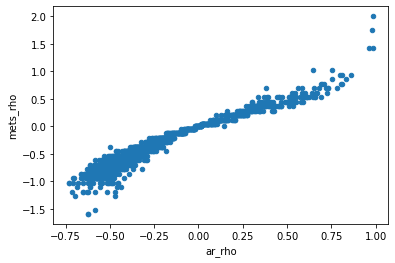

In [8]:
coef_df = pd.DataFrame({'mets_rho':mets_coef, 'ar_rho':ar_coef})
coef_df.plot.scatter(x='ar_rho',y='mets_rho')

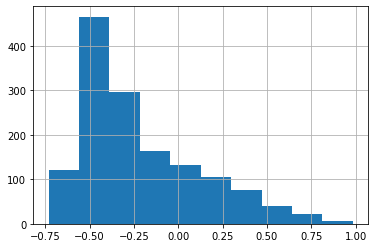

In [9]:
coef_df['ar_rho'].hist()

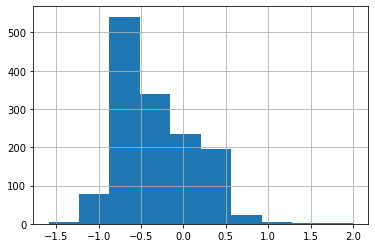

In [10]:
coef_df['mets_rho'].hist()

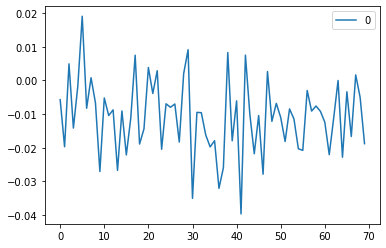

In [11]:
pd.DataFrame(ts).plot()

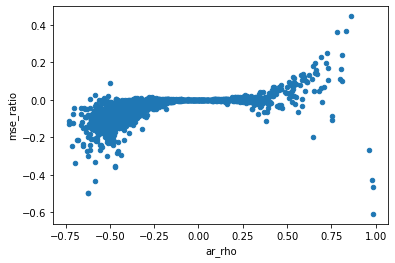

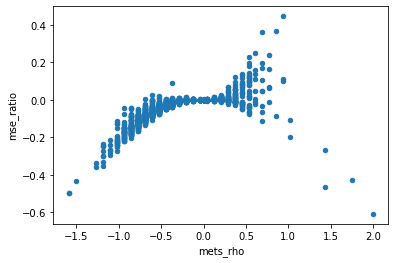

In [12]:
fitted_df = pd.DataFrame({'mets_rho':mets_coef, 'ar_rho':ar_coef,
                         'mets_mse':mets_mse, 'ar_mse':ar_mse})
fitted_df['mse_ratio'] = (fitted_df['mets_mse'] - fitted_df['ar_mse'])/fitted_df['ar_mse']
fitted_df.plot.scatter(x='ar_rho',y = 'mse_ratio')
fitted_df.plot.scatter(x='mets_rho',y = 'mse_ratio')

In [13]:
print(fitted_df['mse_ratio'].mean())
print(fitted_df['mse_ratio'].median())

-0.04480882165646575
-0.021278905253075672


In [14]:
coef_df.corr()

,mets_rho,ar_rho
mets_rho,1.000000,0.966895
ar_rho,0.966895,1.000000
